In [1]:
from super_gradients.training import models
import cv2
from futstats.annotations.anns import Detection
import matplotlib.pyplot as plt
from super_gradients.training.processing import DetectionCenterPadding, StandardizeImage, NormalizeImage, ImagePermute, ComposeProcessing, DetectionLongestMaxSizeRescale

[2023-10-14 20:58:08] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/fer/sg_logs/console.log


[2023-10-14 20:58:09] WARNING - __init__.py - Failed to import pytorch_quantization
/home/fer/miniconda3/envs/futstats/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-10-14 20:58:11] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-10-14 20:58:11] WARNING - export.py - Failed to import pytorch_quantization
[2023-10-14 20:58:11] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [2]:
import torch
print(torch.__version__)
torch.cuda.is_available()

True

1.13.1


In [3]:
%load_ext autoreload
%autoreload 2

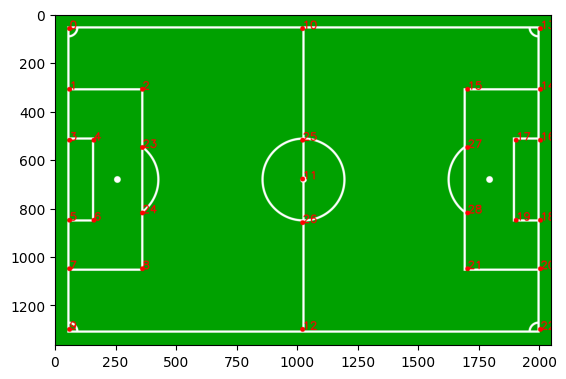

In [4]:
field = cv2.cvtColor(cv2.imread('../images/field_2d.jpg'), cv2.COLOR_BGR2RGB)
POINT2POINT2D = {
    "0" : (60, 60),
    "1" : (60,310),
    "2" : (360,310),
    "3" : (60,520),
    "4" : (160,520),
    "5" : (60,850),
    "6" : (160,850),
    "7" : (60,1050),
    "8" : (360,1050),
    "9" : (60,1300),
    "10": (1020,60),
    "11" : (1020,680),
    "12" : (1020,1300),
    "13" : (2000,60),
    "14" : (2000,310),
    "15" : (1700,310),
    "16" : (2000,520),
    "17" : (1900,520),
    "18" : (2000,850),
    "19" : (1900,850),
    "20" : (2000,1050),
    "21" : (1700,1050),
    "22" : (2000,1300),
    "23" : (360,550),
    "24" : (360,820),
    "25" : (1020,520),
    "26" : (1020,860),
    "27" : (1700,550),
    "28" : (1700,820),
}

NUM_CLASES = len(POINT2POINT2D)


check = field.copy()

for id_, coord in POINT2POINT2D.items():
    check = cv2.circle(check, coord, 10, (255, 0, 0), -1)
    check = cv2.putText(check, id_, coord, cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0),3)

plt.imshow(check)

In [5]:
cktp_path = "./checkpoints/FIELD_KEYPOINTS_COCO/ckpt_best.pth"

model = models.get("yolo_nas_s",
                num_classes=NUM_CLASES,
                checkpoint_path=cktp_path)


model.set_dataset_processing_params(
    image_processor = ComposeProcessing(
    [
        DetectionLongestMaxSizeRescale(output_shape=(636, 636)),
        DetectionCenterPadding(output_shape=(640, 640), pad_value=114),
        StandardizeImage(max_value=255.0),
        ImagePermute(permutation=(2, 0, 1)),
    ]
)
)

[2023-10-14 20:58:38] INFO - checkpoint_utils.py - Successfully loaded model weights from ./checkpoints/FIELD_KEYPOINTS_COCO/ckpt_best.pth EMA checkpoint.


In [13]:
img = cv2.cvtColor(cv2.imread('../images/frame3.png'), cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(cv2.imread(
    "/home/fer/Escritorio/futstatistics/datasets/dataset6_keypoints/dataset6_keypoints_YOLOV5/train/images/3_jpg.rf.8f6bcc82fd3a7c2316e9a4af9c14d1de.jpg"
), cv2.COLOR_BGR2RGB)

In [14]:

results = list(model.predict(img, conf=0.3))[0]
detections = Detection.from_yoloNas(pred=results)

[2023-10-14 21:00:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


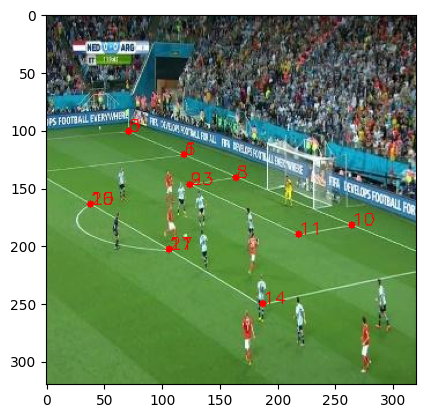

In [15]:

points = img.copy()

for detection in detections:
    x2, y2 = detection.rect.bottom_right.int_xy_tuple
    x1, y1 = detection.rect.top_left.int_xy_tuple
    # get the center of the box
    center = (int((x1 + x2) / 2),int((y1 + y2) / 2))
    points = cv2.circle(points, center, 3, (255, 0, 0), -1)
    points = cv2.putText(points, str(detection.class_name), center, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0),1)



plt.imshow(points)

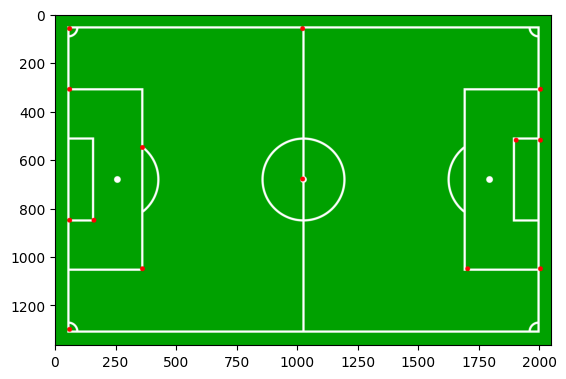

In [17]:
src_points = []
dst_points = []


anns_2d = field.copy()


for detection in detections:
    x2, y2 = detection.rect.bottom_right.int_xy_tuple
    x1, y1 = detection.rect.top_left.int_xy_tuple
    center = (int((x1 + x2) / 2),int((y1 + y2) / 2))
    points_2d = POINT2POINT2D[str(detection.class_name)]
    src_points.append(center)
    dst_points.append(points_2d)
    anns_2d = cv2.circle(anns_2d,points_2d, 10, (255, 0, 0), -1)


plt.imshow(anns_2d)

In [ ]:
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7695
    │   ├── Epoch N-1      = 0.7709 ([32m↘ -0.0014[0m)
    │   └── Best until now = 0.7492 ([31m↗ 0.0204[0m)
    ├── Ppyoloeloss/loss_iou = 0.2156
    │   ├── Epoch N-1      = 0.2157 ([32m↘ -1e-04[0m)
    │   └── Best until now = 0.2081 ([31m↗ 0.0075[0m)
    ├── Ppyoloeloss/loss_dfl = 0.5226
    │   ├── Epoch N-1      = 0.5227 ([32m↘ -0.0[0m)
    │   └── Best until now = 0.5217 ([31m↗ 0.0009[0m)
    ├── Ppyoloeloss/loss = 1.5698
    │   ├── Epoch N-1      = 1.5715 ([32m↘ -0.0016[0m)
    │   └── Best until now = 1.5392 ([31m↗ 0.0307[0m)
    ├── Precision@0.50 = 0.3277
    │   ├── Epoch N-1      = 0.3281 ([31m↘ -0.0004[0m)
    │   └── Best until now = 0.3307 ([31m↘ -0.003[0m)
    ├── Recall@0.50 = 0.9493
    │   ├── Epoch N-1      = 0.9493 ([37m= 0.0[0m)
    │   └── Best until now = 0.9869 ([31m↘ -0.0376[0m)
    ├── Map@0.50 = 0.9033
    │   ├── Epoch N-1      = 0.9024 ([32m↗ 0.001[0m)
    │   └── Best until now = 0.9088 ([31m↘ -0.0055[0m)
    ├── F1@0.50 = 0.4706
    │   ├── Epoch N-1      = 0.4707 ([31m↘ -0.0001[0m)
    │   └── Best until now = 0.4817 ([31m↘ -0.0111[0m)
    ├── Precision@0.50:0.95 = 0.1957
    │   ├── Epoch N-1      = 0.195  ([32m↗ 0.0006[0m)
    │   └── Best until now = 0.1993 ([31m↘ -0.0036[0m)
    ├── Recall@0.50:0.95 = 0.5712
    │   ├── Epoch N-1      = 0.5701 ([32m↗ 0.0012[0m)
    │   └── Best until now = 0.5903 ([31m↘ -0.0191[0m)
    ├── Map@0.50:0.95 = 0.4786
    │   ├── Epoch N-1      = 0.4778 ([32m↗ 0.0008[0m)
    │   └── Best until now = 0.4901 ([31m↘ -0.0115[0m)
    └── F1@0.50:0.95 = 0.2848
        ├── Epoch N-1      = 0.2846 ([32m↗ 0.0002[0m)
        └── Best until now = 0.2914 ([31m↘ -0.0066[0m)